# How different weather conditions induce forest fires in Algeria

# Introduction

Industrial and agricultural activity among many other human activities have significantly affected climate change worldwide. Due to the impacts of climate change, shifts in weather conditions now have a greater potential of inducing forest fires. 

Located on the Mediterranean coast, Algeria is a hotspot for forest fires (Hantson et al., 2015), so the increase in fires due to climate change greatly affects the endangered species that live in Algeria, like the Spanish juniper tree (Khater et al., 2019) and barbary macaque (Waterman et al., 2020). Thus, it is important to combat this environmental issue to prevent further decimation and degradation of Algerian forests.

Additionally, while initially counterintuitive, humid regions with high annual rainfall correlate with fire hotspots (Aini et al., 2019) in the Bejaia region. In the winter months, there is high annual rainfall which promote the growth of vegetation, but in the summer months when the whether is hot and dry, the abundance of vegetation functions as biofuel for forest fires. (Aini et al., 2019). Ergo, the combination of dry summers and high rainfall in other seasons results in a fast evaporation of water in the summer, causing the abundance of biomass to quickly dry out and become biofuel to increase the occurrence of forest fires. 

To start our analysis, we examined the dataset from the Center for Machine Learning and Intelligent Systems of the University of California in Irvine. This center mainly focuses on research in the field of machine learning and intelligent systems and aims to develop algorithms to solve real-world issues in the 21st century. The specific dataset used in our analyses is called the Algerian Forest Fires dataset which contains data on two regions in Algeria: Bejaia (Northeast of Algeria) and Sidi Bel Abbes (Northwest of Algeria). The dataset contains 122 observations for each region from June 2012 to September 2012. Being a coastal city, Bejaia is more representative of the Mediterranean climate of Algeria and is better suited for our analysis which aims at predicting the occurrence of forest fires from climate change in Algeria.

Focusing on the Bejaia region from the Algerian Forest Fires dataset, we evaluate if relative humidity, rain, and temperature are effective predictors for the occurrence of forest fires in Bejaia from June to September. 


# Methods and Results

**Overview**

Using the K-nearest neighbour classification system, we used relative humidity, wind speed, rain, and temperature to predict whether a new observation would be classified as "fire" or "not fire".

First, we split the data set into a training set and a testing set. We used a 75-25 train-test split to have a balanced trade-off between training an accurate model by using a sufficiently large training data set and getting an accurate evaluation of the classifier's performance by using a sufficiently large test data set. Since we want our code to be reproducible, we used the set seed function to generate the same train-test split each time the code is run. The training set was then further split into a training set and a validation set so that we could tune our model and perform a 5-fold cross-validation to choose a K-value that gave the most accurate prediction. The test set was put aside when training the model so that it wouldn't give uncharacteristically accurate results when we estimated the accuracy of the classifier by predicting observations with new data.

Additionally, we standardized the data, by scaling and centering so the average was 0 and the standard deviation was 1. This ensures that all variables are on a comparable scale to contribute equally in the calculation of the Euclidean distance between the points.

In general, for each predictor, we calculated the Euclidean distance between the new observation and each observation in the training set, placed the distances in ascending order, and classified the new observation to a class ("fire" or "not fire").

As part of our exploratory data analysis, we plotted our variables of interest with a 4x4 group of scatterplots (and their respective distributions), coloured by classes with the expectation that relationships between the variables will be more evident to guide our actual data analysis. 

Finally, the results of our data analysis were visualized using scatterplots where the background colour indicated the predicted classifier for an observation.


In [25]:
# Loading packages
library(dplyr)
library(repr)
library(tidyverse)
library(tidymodels)
library(GGally)
library(cowplot)

## Exploratory Data Analysis

In [26]:
# Reading and tidying data from the web

# read .csv file
algerian_fire <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)

# select the Bejaia region data and set up the right labels
bejaia_fire_0 <- algerian_fire[c(1:122), ]
bejaia_fire <- bejaia_fire_0 %>% 
               select(day, month, year, Classes, Temperature, RH, Ws, Rain) %>%
               mutate(Temperature = as.numeric(Temperature)) %>%
               mutate(RH = as.numeric(RH)) %>%
               mutate(Ws = as.numeric(Ws)) %>%
               mutate(Rain = as.numeric(Rain)) 

# combine three columns and set it to date
bejaia_fire$date <- as.Date(with(bejaia_fire, paste(year, month, day, sep="-")), "%Y-%m-%d") 

# tidy the whole dataset
bejaia_fire_tidy <- bejaia_fire %>% 
                    select(date, Classes,Temperature, RH, Ws, Rain)
bejaia_fire_tidy

date,Classes,Temperature,RH,Ws,Rain
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2012-06-01,not fire,29,57,18,0.0
2012-06-02,not fire,29,61,13,1.3
2012-06-03,not fire,26,82,22,13.1
2012-06-04,not fire,25,89,13,2.5
2012-06-05,not fire,27,77,16,0.0
2012-06-06,fire,31,67,14,0.0
2012-06-07,fire,33,54,13,0.0
2012-06-08,fire,30,73,15,0.0
2012-06-09,not fire,25,88,13,0.2


The columns in the dataset we work with are: the date, the class: fire or not fire, the temperature in degrees Celsius, relative humidity (RH) in percentage, wind speed (Ws) in kilometers per hour (km/h), and rain in millimeters (mm).

In [27]:
# Creating the training dataset

set.seed(80)

# remove space before and after the string
bejaia_fire_tidy$Classes <- trimws(bejaia_fire_tidy$Classes)

# set the label back to factor
bejaia_fire_tidy <- bejaia_fire_tidy %>% 
                    mutate(Classes = as.factor(Classes)) 

# split data into training and testing dataset
bejaia_split <- initial_split(bejaia_fire_tidy, prop = 0.75, strata = Classes)
bejaia_train <- training(bejaia_split)
bejaia_test <- testing(bejaia_split)

In [28]:
# Creating a table for the number of observations in each class

bejaia_table <- bejaia_train %>%
                group_by(Classes)%>%
                summarize(n = n())

'Table 1: Number of Observations for Each Class'
bejaia_table

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 1: Number of Observations for Each Class"

Classes,n
<fct>,<int>
fire,45
not fire,48


The table shows that there are $45$ observations labelled as "fire" and $48$ observations labelled as "not fire" in the training model.

In [29]:
# Preparing the training data for visualization

# preprocess and standardize data by centering and scaling
bejaia_recipe <- recipe(Classes ~ Temperature + RH + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

# apply trained data recipe
bejaia_scaled <- bejaia_recipe %>%  
                 prep() %>%
                 bake(bejaia_train)

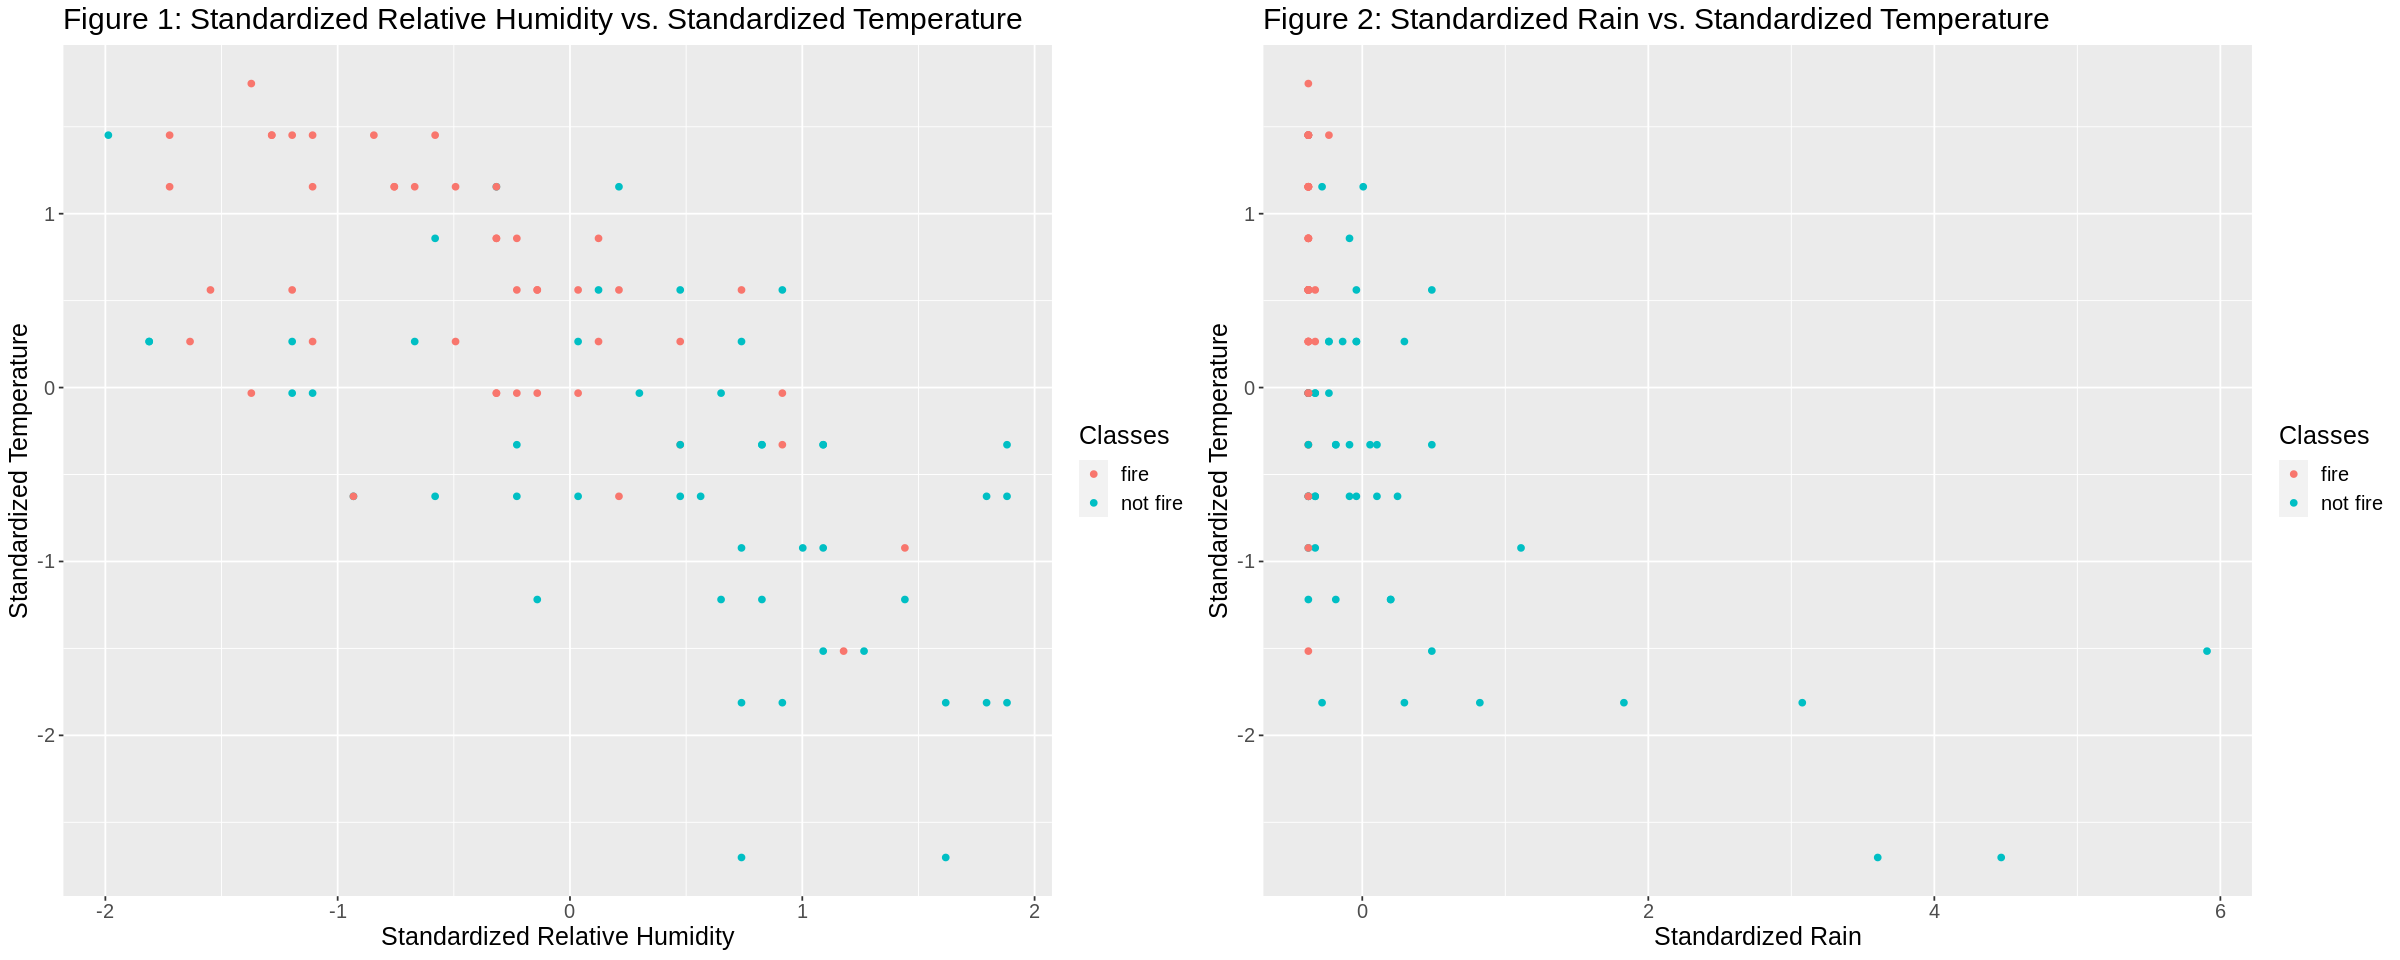

In [30]:
# Creating an exploratory visualization 

options(repr.plot.width = 20, repr.plot.height = 8)

# Standardized Relative Humidity vs. Temperature plot
b_RH_plot <- bejaia_scaled %>% 
             ggplot(aes(x = RH, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 1: Standardized Relative Humidity vs. Standardized Temperature") +
             labs(x = "Standardized Relative Humidity", y = "Standardized Temperature", colour = "Classes")+
             theme(text = element_text(size = 15))

# Standardized Rain vs. Temperature plot
b_Ws_plot <- bejaia_scaled %>% 
             ggplot(aes(x = Rain, y = Temperature, color = Classes)) + 
             geom_point() + 
             ggtitle("Figure 2: Standardized Rain vs. Standardized Temperature") +
             labs(x = "Standardized Rain", y = "Standardized Temperature", colour = "Classes") +
             theme(text = element_text(size = 15))

plot_grid(b_RH_plot, b_Ws_plot)

In Figure 1, we see that with an increase in temperature and a decrease in the amount of relative humidity, forest fires are more likely to occur, as noted by the large number of red data points. Namely, when the standardized temperature is above 0.5 degrees celsius and when the standardized relative humidity is below 1. Hence, temperature and relative humidity are good predictors for the occurrence of forest fires.

In Figure 2, when temperature increases and the amount of rainfall is lower, there are more red data points, indicating that forest fires are more likely to occur  Hence, temperature and rain are also good predictors for the occurrence of forest fires.

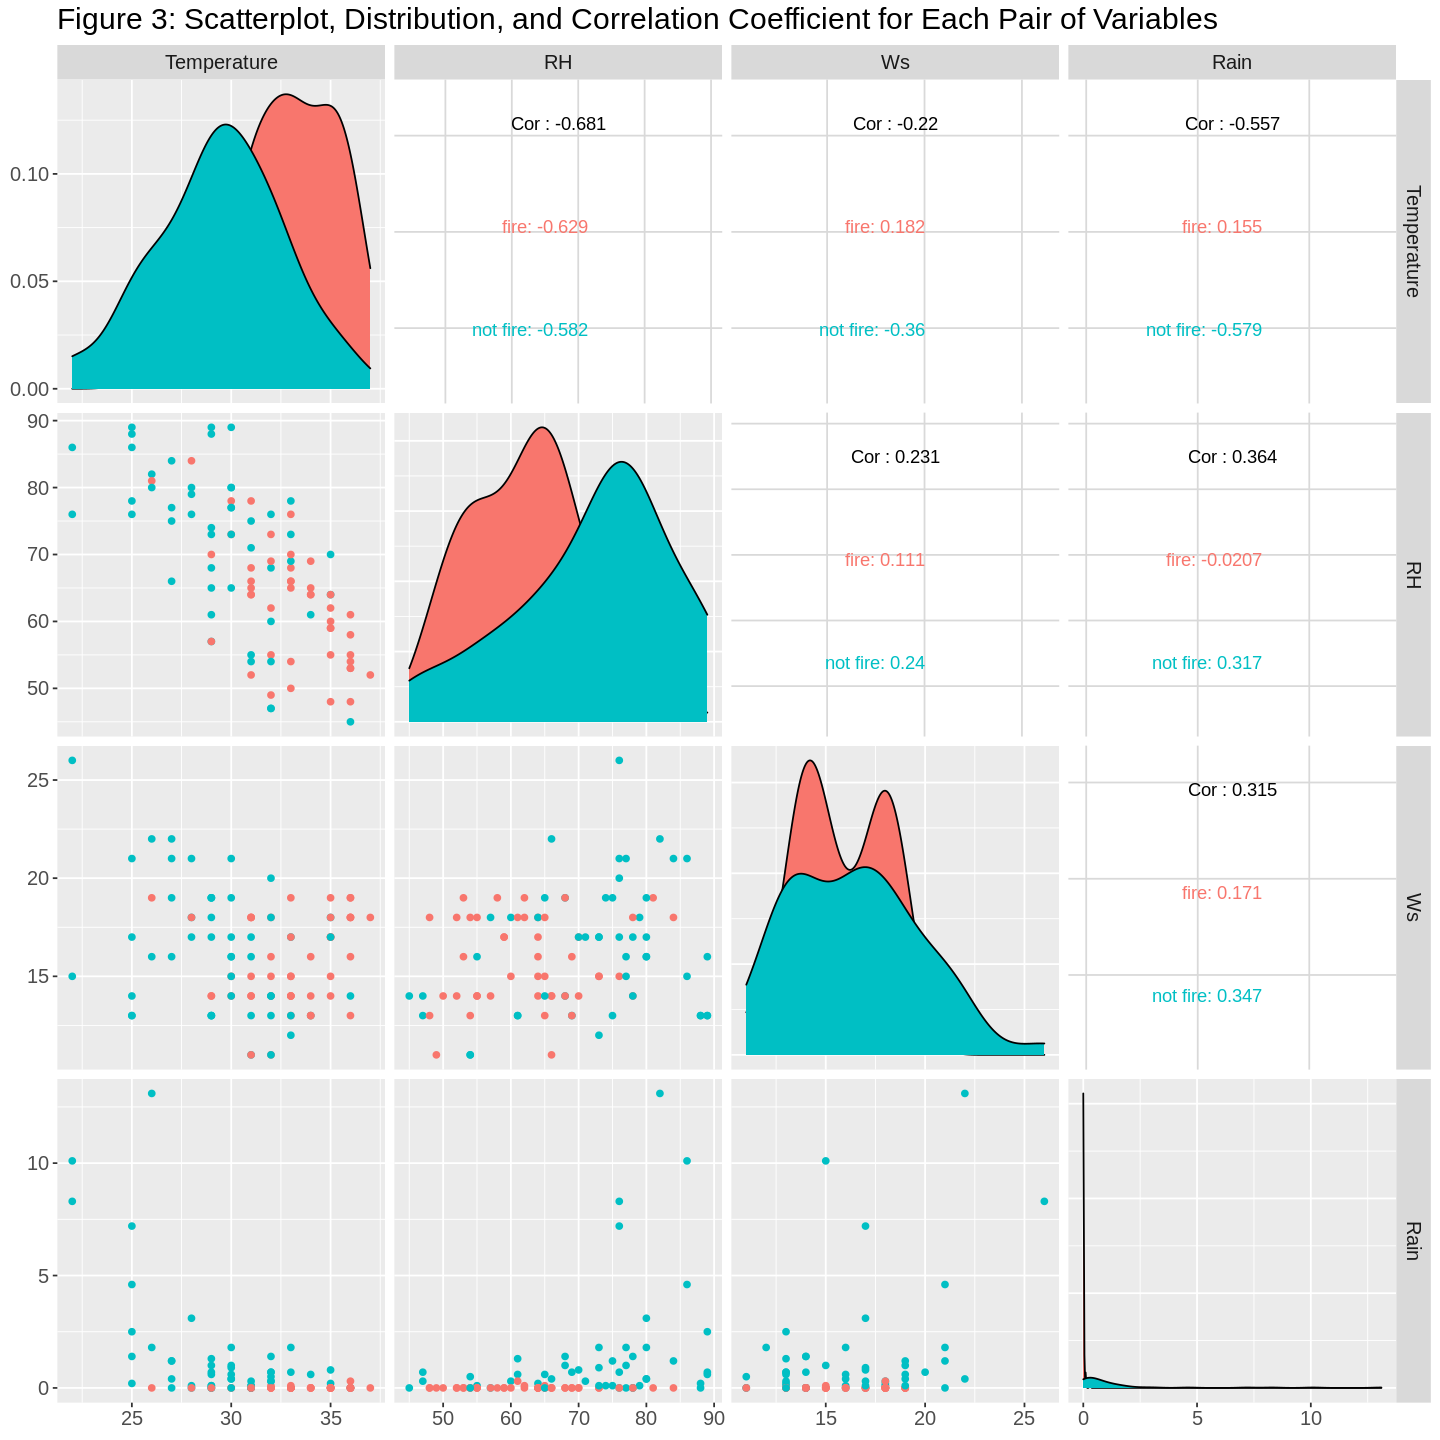

In [31]:
# Creating the final exploratory visualization

options(repr.plot.width = 12, repr.plot.height = 12)

pairs_bejaia <- bejaia_train %>%
                select(Temperature, RH, Ws, Rain) %>%
                ggpairs(ggplot2::aes(colour = bejaia_train$Classes)) +
                ggtitle("Figure 3: Scatterplot, Distribution, and Correlation Coefficient for Each Pair of Variables") +
                theme(text = element_text(size = 15))
pairs_bejaia

From Figure 3, we observe that temperature and relative humidity have a strong, linear, negative relation such that as rain decreases, temperature increases and more forest fires occur. Also, from the last 3 scatterplots on the last row, we can see that there are no fires when there is rain. 

Therefore, in our analysis, we will use temperature, relative humidity, and rain as our predictors as they show that they are the best predictors. And we exclude wind speed because its distribution plot does not show much separation, whereas temperature and relative humidity do. 

# Data Analysis

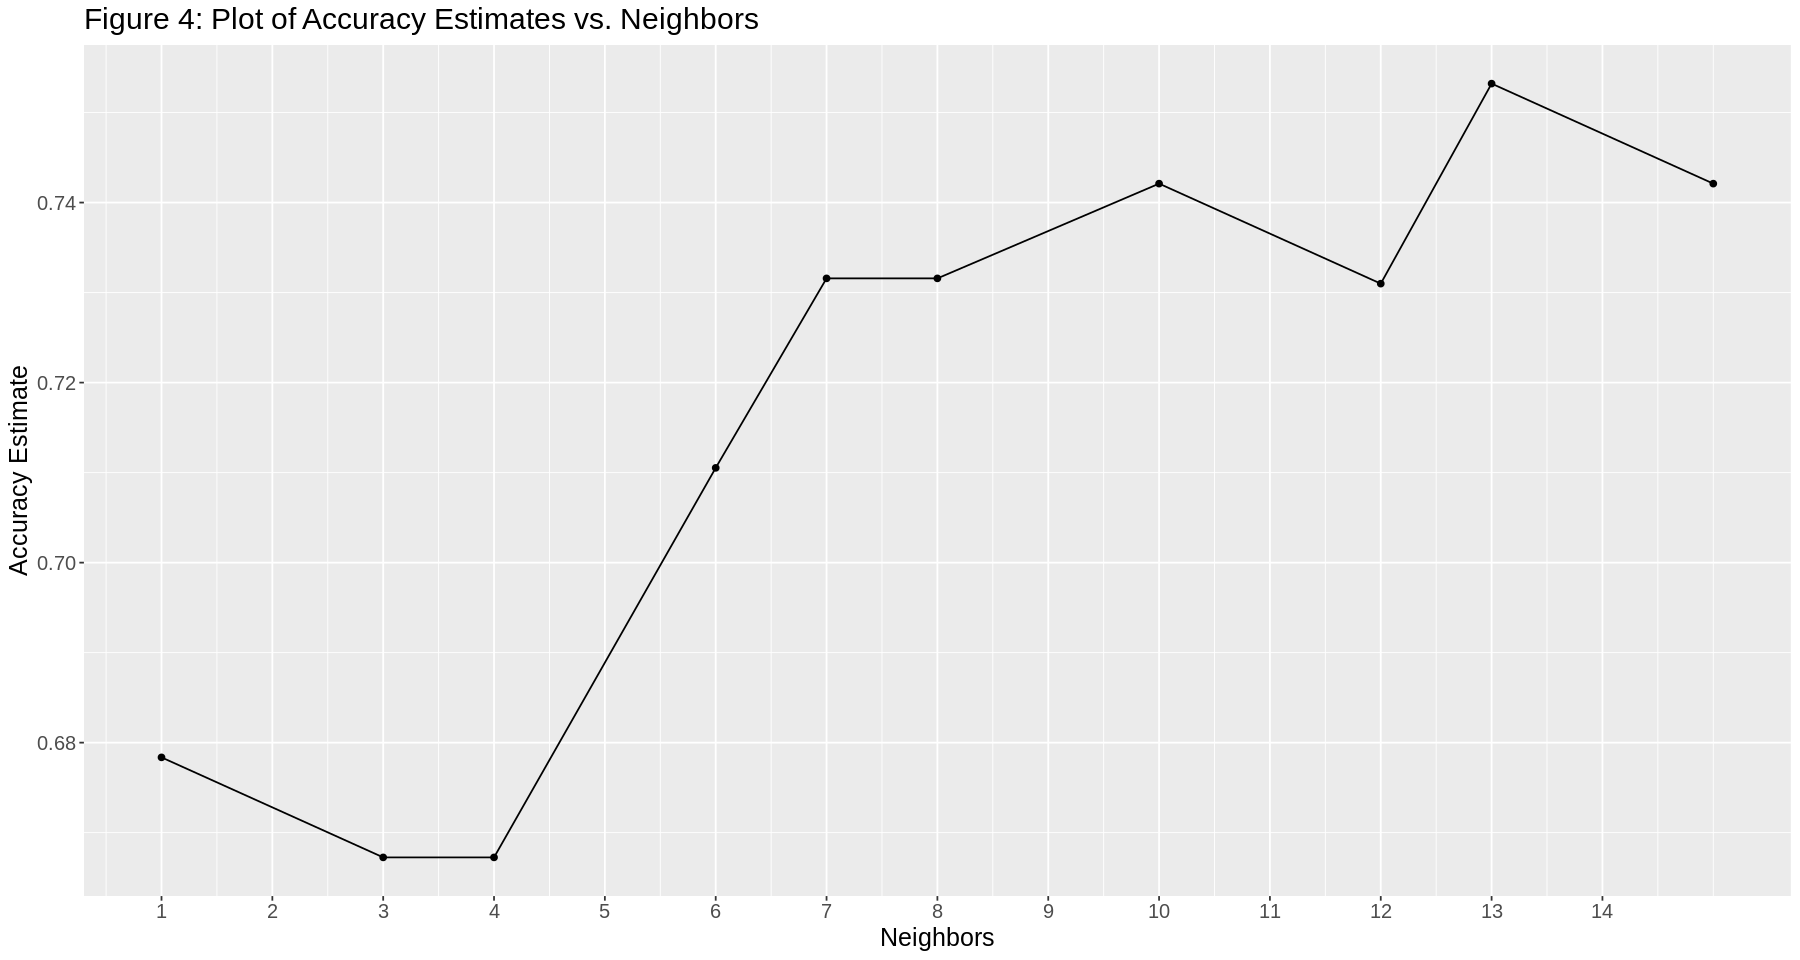

In [32]:
# Finding the best K

# update the recipe
bajaia_recipe <- recipe(Classes ~ Temperature + RH + Rain, data = bejaia_train) %>% 
                 step_center(all_predictors()) %>%
                 step_scale(all_predictors())

# set up the model
bejaia_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
               set_engine("kknn") %>%
               set_mode("classification") 

# perform 5-fold cross-validation 
bejaia_vfold <- vfold_cv(bejaia_train, v = 5, strata = Classes)

bejaia_workflow <- workflow() %>%
                   add_recipe(bejaia_recipe) %>%
                   add_model(bejaia_spec) %>%
                   tune_grid(resamples = bejaia_vfold, grid = 10) %>%
                   collect_metrics() 

# determine the accuracy of the classifier
bejaia_accuracy <- bejaia_workflow %>% 
                   filter(.metric == "accuracy")

# plot Accuracy Estimates vs. Neighbours
options(repr.plot.width = 15, repr.plot.height = 8)

accuracy_plot <- bejaia_accuracy %>% 
                 ggplot(aes(x = neighbors, y = mean)) + 
                 geom_point() + 
                 geom_line() + 
                 ggtitle("Figure 4: Plot of Accuracy Estimates vs. Neighbors") +
                 labs(x = "Neighbors", y = "Accuracy Estimate") +
                 scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
                 theme(text = element_text(size = 15))
accuracy_plot

From Figure 4, we observe that $K = 13$ will produce the best accuracy. We are sure of our K-value as performing cross-validation gives us a more unbiased estimate of the accuracy of our K value since data is shuffled and split into several parts and the mean of the several splits is used as the estimate. Knowing this, we can build a new model specification with $13$ neighbours.

In [33]:
# Retraining the model

# set up model with the best number of neighbours
bejaia_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
                    set_engine("kknn") %>%
                    set_mode("classification")

bejaia_result <- workflow() %>%
                 add_recipe(bejaia_recipe) %>%
                 add_model(bejaia_spec_best) %>%
                 fit(data = bejaia_train)

# perform prediction
bejaia_predict <- predict(bejaia_result, bejaia_test) %>%
                  bind_cols(bejaia_test)

# determine the accuracy of the classifier
accuracies <- bejaia_predict %>%
              metrics(truth = Classes, estimate = .pred_class) %>%
              filter(.metric == "accuracy") %>%
              select(.estimate) %>%
              pull()

# confusion matrix
'Table 2: Confusion Matrix'
bejaia_conf <- bejaia_predict %>%
               conf_mat(truth = Classes, estimate = .pred_class)
bejaia_conf

[1] "Table 2: Confusion Matrix"

          Truth
Prediction fire not fire
  fire       11        5
  not fire    3       10

The confusion matrix shows us that $21$ observations were correctly labelled. However, $3$ observations were labelled as not fires when they were truly fires and $5$ observations were labelled as fires when they were in fact not fires. Our classifier's predictions can also be visualized below for easier interpretation of our results.

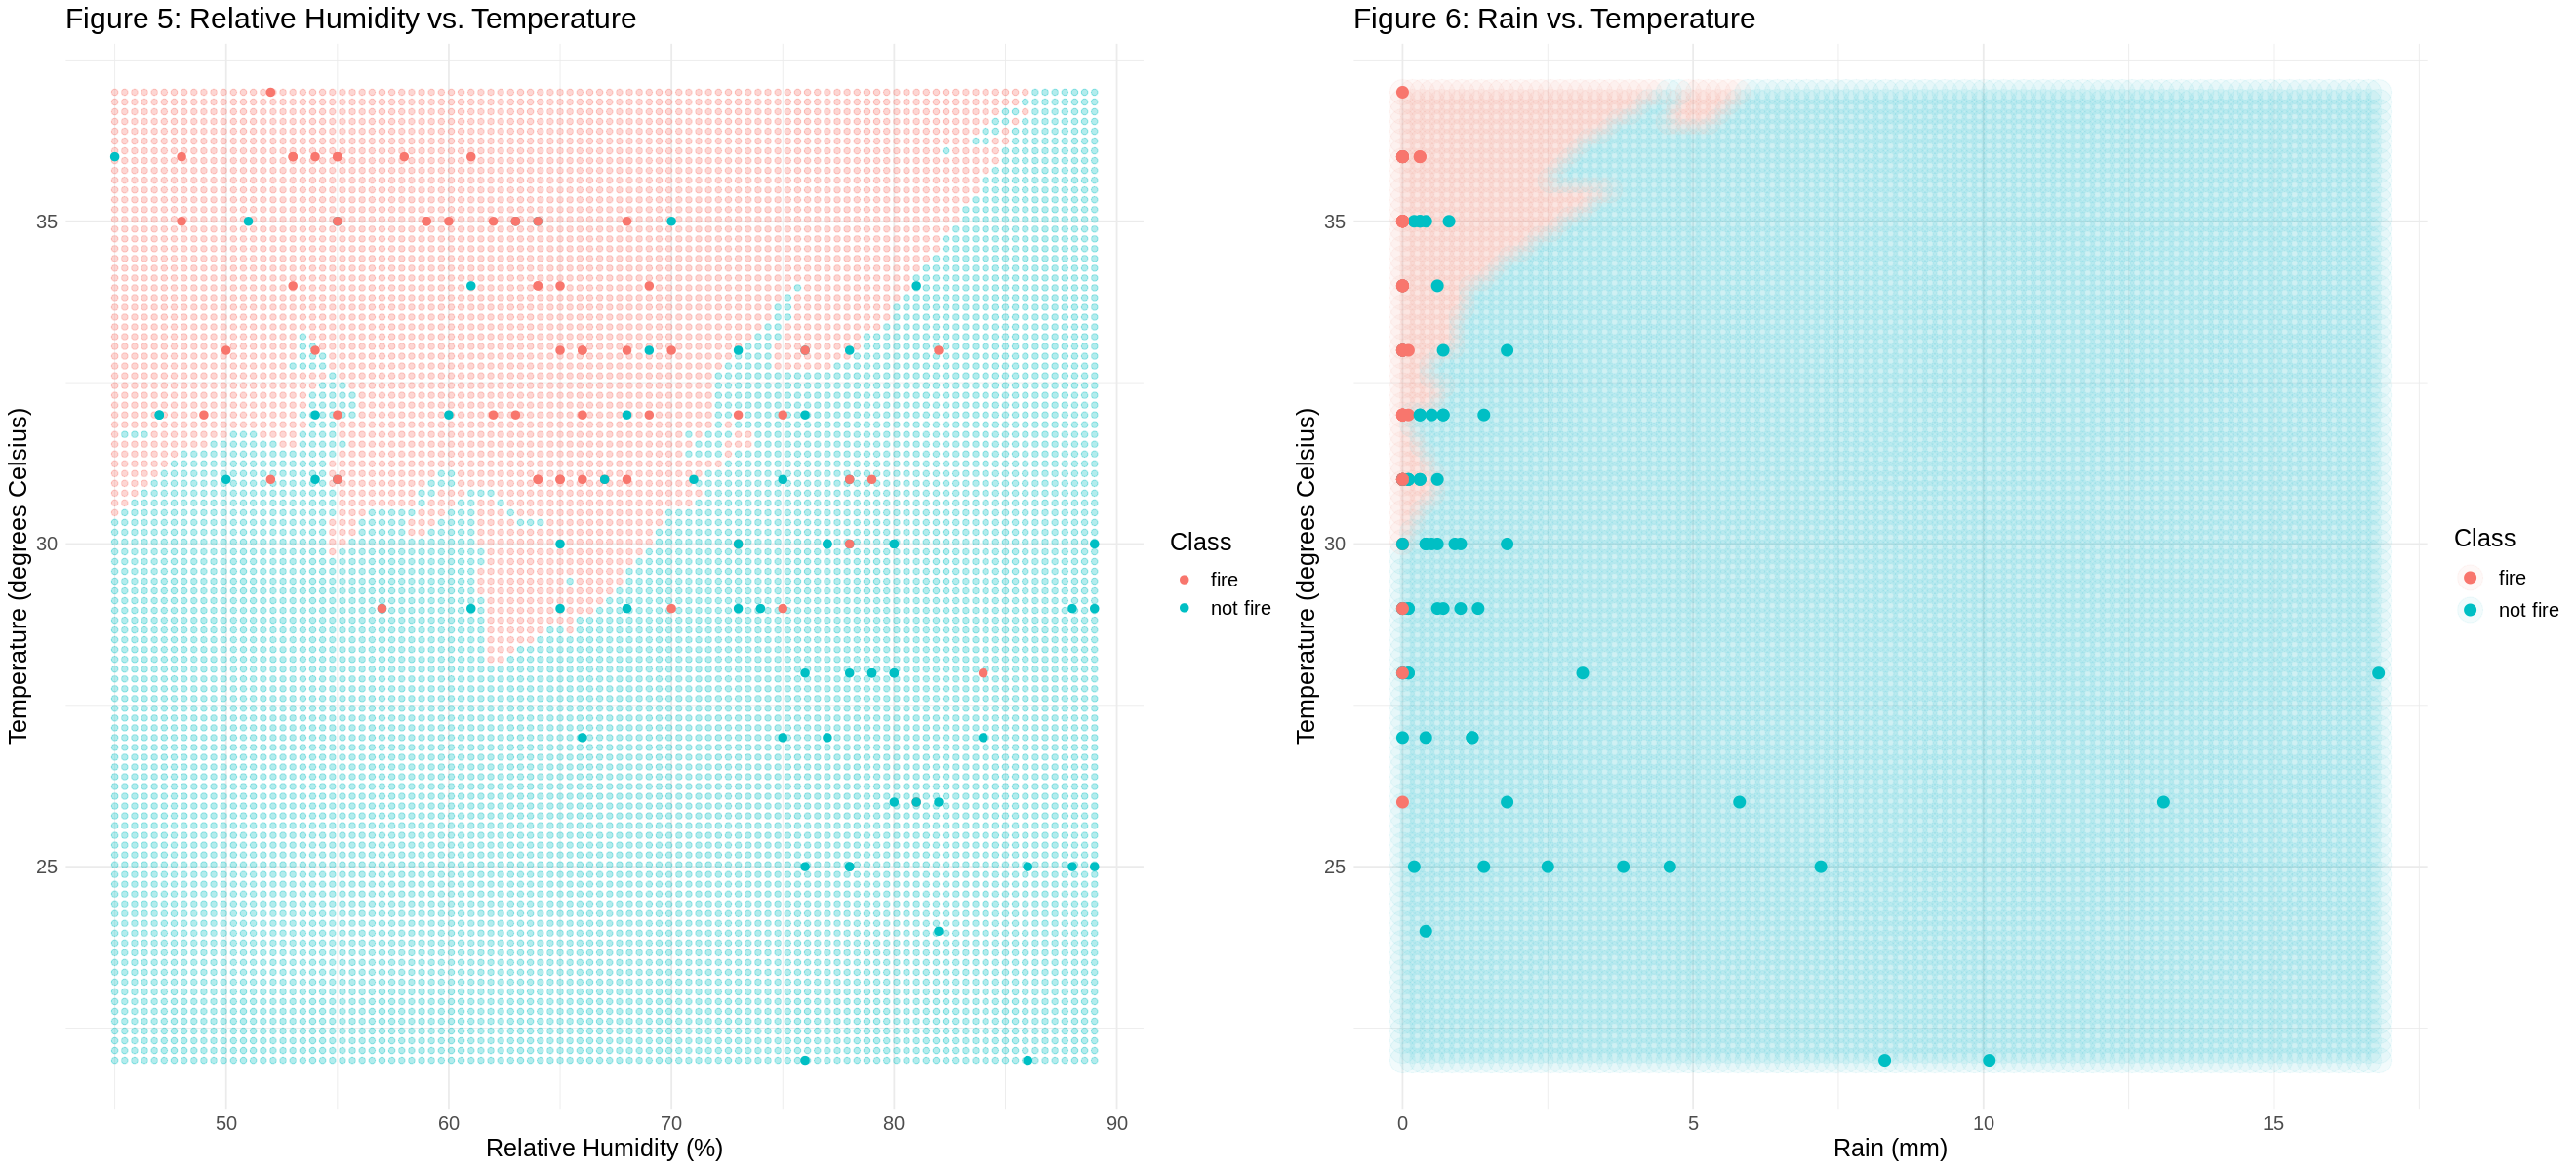

In [40]:
# Visualizing final results

options(repr.plot.width = 22, repr.plot.height = 10)

# Relative Humidity vs. Temperature
bejaia_recipe_2 <- recipe(Classes ~ Temperature + RH, data = bejaia_train) %>% 
                   step_center(all_predictors()) %>%
                   step_scale(all_predictors())

RH_seq <- seq(from = min(bejaia_fire_tidy$RH, na.rm = TRUE), 
          to = max(bejaia_fire_tidy$RH, na.rm = TRUE), 
          length.out = 100)

Temperature_seq <- seq(from = min(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
                   to = max(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
                   length.out = 100)

grid_points <- expand.grid(RH = RH_seq,
               Temperature = Temperature_seq)

grid_predicted <- workflow() %>%
                  add_recipe(bejaia_recipe_2) %>%
                  add_model(bejaia_spec_best) %>%
                  fit(data = bejaia_train) %>%
                  predict(new_data = grid_points) %>%
                  cbind(grid_points)

grid_humidity_plot <- grid_predicted %>%
                      ggplot(aes(x = RH, y = Temperature, color = .pred_class)) + 
                      geom_point(alpha = 0.3) + 
                      geom_point(data = bejaia_fire_tidy,
                      aes(x = RH, y = Temperature, color = Classes), 
                      size = 2) + 
                      ggtitle("Figure 5: Relative Humidity vs. Temperature") +
                      theme_minimal() + 
                      labs(x = "Relative Humidity (%)", y = "Temperature (degrees Celsius)", colour = "Class") +
                      theme(text = element_text(size = 15))

# Rain vs. Temperature
bejaia_recipe_3 <- recipe(Classes ~ Temperature + Rain, data = bejaia_train) %>% 
                   step_center(all_predictors()) %>%
                   step_scale(all_predictors())

Rain_seq <- seq(from = min(bejaia_fire_tidy$Rain, na.rm = TRUE), 
            to = max(bejaia_fire_tidy$Rain, na.rm = TRUE), 
            length.out = 100)

Temperature_seq <- seq(from = min(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
                   to = max(bejaia_fire_tidy$Temperature, na.rm = TRUE), 
                   length.out = 100)

grid_points <- expand.grid(Rain = Rain_seq,
               Temperature = Temperature_seq)

grid_predicted <- workflow() %>%
                  add_recipe(bejaia_recipe_3) %>%
                  add_model(bejaia_spec_best) %>%
                  fit(data = bejaia_train) %>%
                  predict(new_data = grid_points) %>%
                  cbind(grid_points)

grid_rain_plot <- grid_predicted %>%
                  ggplot(aes(x = Rain, y = Temperature, color = .pred_class)) + 
                  geom_point(alpha = 0.05, size = 7) + 
                  geom_point(data = bejaia_fire_tidy,
                  aes(x = Rain, y = Temperature, color = Classes), size = 3) + 
                  ggtitle("Figure 6: Rain vs. Temperature") +
                  theme_minimal() + 
                  labs(x = "Rain (mm)", y = "Temperature (degrees Celsius)", colour = "Class") +
                  theme(text = element_text(size = 15))

plot_grid(grid_humidity_plot, grid_rain_plot)

The figures above display our final results along with our classifier's accuracy and decision boundaries that divide our observations into two categories: "fire" and "not fire". 

In Figure 5, relative humidity and temperature were used as predictors and the background color represents the decision our classifier made during the classification process. It can be observed that $12$ observations were incorrectly labelled as not fires when they were truly fires by looking at the number of red points in the blue area. 

Similarly, by using rain and temperature as predictors in Figure 6, we see the classifier's mispredictions of $3$ observations labelled as not fires when they were truly fires. Moreover, in Figure 6, the background color enables us to deduce that there are a larger number of observations classified as "not fires" and very few observations classified as "fires" when temperature and rain are used as predictors. In comparison, in Figure 5, the observations labelled as "fire" and "not fire" are almost equally distributed when relative humidity and temperature are used as predictors instead.

# Discussion

We found that our classifier gives has a 72.4% accuracy. Namely, our model correctly predicts whether a fire occurred on a specific date between June to September 72.4% of the time. Indeed, our classifier correctly predicted 11 observations as fires when they were truly fires and 10 observations as not fires when they were truly not fires. **By comparing Figures 5 and 6, we can conclude that the combination of rain and temperature predictors can provide a better predication for the occurrence of forest fires compared to the other predictors, based on our dataset. This is partly in accordance with what we expected.** However, after the analysis and visualization of the results, we can more confidently say that rain and temperature have a much larger influence as predictors relative to relative humidity. **reiterate our hypothesis?**

Deciding which environmental factors are able to most accurately predict when a forest fire is likely to occur is critical in planning to mitigate the effects of large forest fires, or preventing forest fires from happening altogether — especially if we have sufficient warning. This way, inhabitants can take the necessary precautions to prevent fire propagation and preserve the environment while reducing air pollution. If a forest fire is effectively predicted early on, the fire can be more quickly and efficiently extinguished. 

One of the limitations of our dataset is that we only have data from June to September when the temperatures are relatively high and rainfall is relatively low. According to the paper from Aini et al. (2019, 2020), a unique characteristic of the Mediterranean climate is that rain and high temperatures exist seperately in a year. Therefore, a more in-depth look regarding data from all the months of a year should be the focus of future analyses. In particular, to see if rain and temperature will still have the same level of influence on the occurrence of forest fires. Another limitation is the relatively small data set we have. With a larger data set, any analyses we do would result in greater confidence that they could be generalized to similar regions. 

The other area included in our original data set is for the Sidi Bel Abbes region, an inland city with relatively low rainfall compare to Bejaia. Since heavy rainfall is correlated with an increased amount of biomass which can become fuel for forest fires in the summer (Aini et al. 2019, 2020), future questions could also focus on examining Aini's findings to see if regions with differing rainfalls from different regions corroborate his findings. **Additionally, by comparing between regions, further work can be done to support the components of the Fire Weather Index (FWI) system.**

---

# References

Aini, A., Curt, T., & Bekdouche, F. (2019). Modelling fire hazard in the southern mediterranean fire rim (bejaia region, northern algeria). Environmental Monitoring and Assessment, 191(12), 1-19. https://doi.org/10.1007/s10661-019-7931-0

Aini, A., Curt, T., & Dupire, S. (2020). Fire activity in mediterranean forests (the algerian case). Fire (Basel, Switzerland), 3(58), 58. https://doi.org/10.3390/fire3040058

Abid, F., & Izeboudjen, N. (2020). Predicting forest fire in algeria using data mining techniques: Case study of the decision tree algorithm. (pp. 363-370). Springer International Publishing. https://doi.org/10.1007/978-3-030-36674-2_37

Hantson, S., Pueyo, S., & Chuvieco, E. (2015). Global fire size distribution is driven by human impact and climate: Spatial trends in global fire size distribution. Global Ecology and Biogeography, 24(1), 77-86. https://doi.org/10.1111/geb.12246

Khater, N., Khater, N., Benbouza, H., & Benbouza, H. (2019). Preservation of juniperus thurifera L.: A rare endangered species in algeria through in vitro regeneration. Journal of Forestry Research, 30(1), 77-86. https://doi.org/10.1007/s11676-018-0628-3

Waterman, J. O., Campbell, L. A. D., Maréchal, L., Pilot, M., & Majolo, B. (2020). Effect of human activity on habitat selection in the endangered barbary macaque. Animal Conservation, 23(4), 373-385. https://doi.org/10.1111/acv.12543